<a href="https://colab.research.google.com/github/jiiinchoi/MAI-Lab./blob/main/Transformer_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실전과제

## Setup

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.2 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 867.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

### Download the dataset

In [3]:
# 데이터셋 다운로드
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

# train/ validation 분리
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.Y657XN_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.Y657XN_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.Y657XN_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
# train dataset에서 예제 출력
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> 포르투갈어 예제:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> 영어 예제:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> 포르투갈어 예제:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> 영어 예제:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Tokenizer Set up

이 튜토리얼에서는 [서브워드 토크나이저](https://www.tensorflow.org/text/guide/subwords_tokenizer) 튜토리얼에 내장된 토크나이저를 사용합니다.

In [5]:
# 모델 다운로드 및 압축 해제
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',  # 저장할 파일 이름
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',  # 다운로드 URL
    cache_dir='.',       # 캐시 디렉토리 위치
    cache_subdir='',     # 캐시 서브디렉토리 위치
    extract=True         # 파일 압축 해제
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [6]:
tokenizers = tf.saved_model.load(
    './ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter'
)


In [7]:
# tokenizers.en 객체의 사용 가능한 메소드와 속성 리스트 출력
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [8]:
# TensorFlow 데이터셋에서 로드한 배치의 영어 문장 출력
for en in en_examples.numpy():
  print(en.decode('utf-8'))   # 영어 문장을 UTF-8로 디코딩하여 출력

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [9]:
# 로드된 토크나이저를 사용하여 영어 문장을 토큰 ID로 변환
encoded = tokenizers.en.tokenize(en_examples)

# 패딩된 토큰 ID의 배치 출력
for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [10]:
# 토큰 ID를 다시 사람이 읽을 수 있는 텍스트로 변환
round_trip = tokenizers.en.detokenize(encoded)

# 변환된 텍스트 출력
for line in round_trip.numpy():
  print(line.decode('utf-8'))    # 텍스트를 UTF-8로 디코딩하여 출력

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [11]:
# 토큰 ID를 다시 개별 토큰으로 변환
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [12]:
sample_string = tf.constant(['Transformer is awesome.'])

tokenized_string = tokenizers.en.tokenize(sample_string)

print(tokenized_string.numpy())
print(tokenizers.en.lookup(tokenized_string))
print(tokenizers.en.detokenize(tokenized_string).numpy())

[[   2 1761  227   80 1920   15    3]]
<tf.RaggedTensor [[b'[START]', b'transform', b'##er', b'is', b'awesome', b'.', b'[END]']]>
[b'transformer is awesome .']


:데이터 세트의 example당 토큰 분포

In [13]:
# 포르투갈어와 영어 문장들의 토큰 개수를 저장할 리스트
lengths = []

# 훈련 데이터셋의 배치를 순회하며 토큰 개수 계산
for pt_examples, en_examples in train_examples.batch(1024):
  # 포르투갈어 문장 토큰화 및 토큰 개수 저장
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  # 영어 문장 토큰화 및 토큰 개수 저장
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())

  print('.', end='', flush=True)  # 진행 상태 표시

...................................................

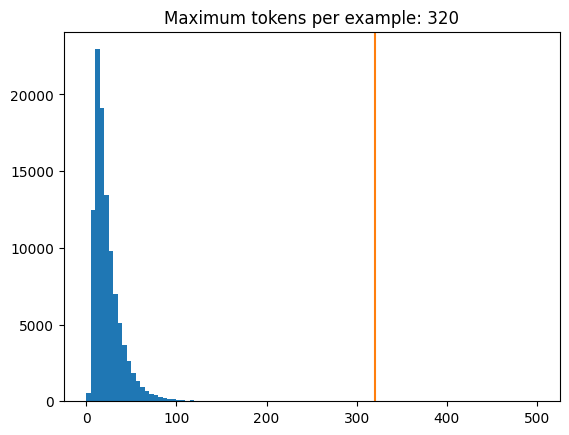

In [14]:
# 모든 토큰 개수를 하나의 배열로 결합
all_lengths = np.concatenate(lengths)

# 히스토그램으로 토큰 개수 분포 시각화
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())

# 가장 긴 문장의 토큰 개수 표시
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())

# 그래프 제목 설정
plt.title(f'Maximum tokens per example: {max_length}');

 데이터 파이프라인 설정

In [15]:
print(tokenized_string)
print(tokenized_string.to_tensor())

<tf.RaggedTensor [[2, 1761, 227, 80, 1920, 15, 3]]>
tf.Tensor([[   2 1761  227   80 1920   15    3]], shape=(1, 7), dtype=int64)


In [16]:
MAX_TOKENS = 128

def prepare_batch(pt, en):
    # pt: 포르투갈어 문장
    pt = tokenizers.pt.tokenize(pt) # 문자열 → 토큰 ID
    pt = pt[:, :MAX_TOKENS] # 최대 길이 제한
    pt = pt.to_tensor() # 패딩 채워서 dense 텐서로

    # en: 영어 문장
    en = tokenizers.en.tokenize(en) # 문자열 → 토큰 ID
    en = en[:, :(MAX_TOKENS + 1)] # <start>/<end> 포함해서 잘라줌

    en_inputs = en[:, :-1].to_tensor() # 마지막 토큰(<end>) 제외 → 디코더 입력
    en_labels = en[:, 1:].to_tensor() # 첫 토큰(<start>) 제외 → 정답 레이블

    return (pt, en_inputs), en_labels


In [17]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128

In [18]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)  # 데이터셋을 섞음
      .batch(BATCH_SIZE)     # 배치 크기로 나눔
      .map(prepare_batch, tf.data.AUTOTUNE)  # 각 배치에 대해 prepare_batch 함수 적용
      .prefetch(buffer_size=tf.data.AUTOTUNE))  # 데이터를 사전에 가져와 성능 향상

 </section>

## Dataset 테스트

In [19]:
# dataset -> batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [20]:
# 훈련 배치의 첫 번째 요소 가져오기
for (pt, en), en_labels in train_batches.take(1):
  break

# 포르투갈어 입력, 영어 입력, 영어 레이블의 shape 출력
print(pt.shape)
print(en.shape)
print(en_labels.shape)

(128, 79)
(128, 71)
(128, 71)


In [21]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   83   94 2532   93  331 4656   88   15    0], shape=(10,), dtype=int64)
tf.Tensor([  83   94 2532   93  331 4656   88   15    3    0], shape=(10,), dtype=int64)


In [22]:
def positional_encoding(length, depth):
  # depth: 임베딩 차원 수 → sin / cos 나누기 위해 반으로 쪼갬
  depth = depth / 2

  # 각 토큰의 위치 인덱스
  positions = np.arange(length)[:, np.newaxis]

  # 각 차원 인덱스(0~depth-1)를 0~1 사이로 정규화
  depths = np.arange(depth)[np.newaxis, :] / depth

  # 각 차원마다 다른 주파수를 쓰기 위한 스케일 값
  angle_rates = 1 / (10000 ** depths)
  angle_rads  = positions * angle_rates

  # 짝수 차원: sin, 홀수 차원: cos 형태로 붙여서 위치 정보 만듦
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1
  )

  # 최종적으로 TF 텐서로 변환해서 반환
  return tf.cast(pos_encoding, dtype=tf.float32)


(2048, 512)


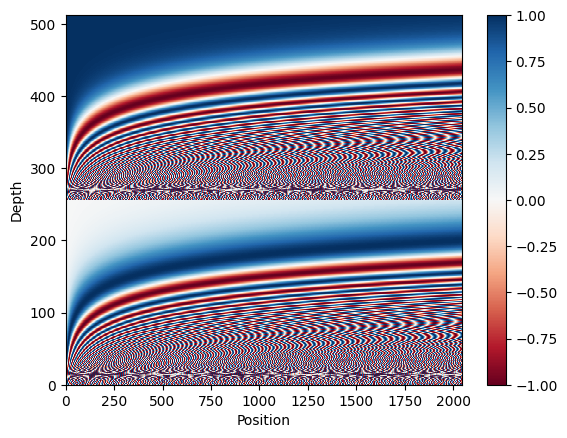

In [23]:
# 위치 인코딩 생성
pos_encoding = positional_encoding(length=2048, depth=512)

# 생성된 위치 인코딩의 형상 확인
print(pos_encoding.shape)  # (2048, 512)

# 위치 인코딩 시각화
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')  # 깊이에 따른 위치 인코딩 시각화
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()  # 컬러바 추가
plt.show()

In [24]:
#positional_encoding 함수는 길이가 2048, 깊이가 512인 위치 인코딩 행렬을 생성합니다.

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model    # 임베딩 차원
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)  # 단어 임베딩 레이어
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)   # 위치 인코딩

  def compute_mask(self, *args, **kwargs):
    # 마스크 계산 (패딩된 부분을 모델이 무시하도록 함)
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]    # 입력 시퀀스의 길이
    x = self.embedding(x)    # 단어 임베딩 적용
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    # 임베딩 크기 조정
    x = x + self.pos_encoding[tf.newaxis, :length, :]     # 위치 인코딩 추가
    return x

In [25]:
# 포르투갈어와 영어를 위한 위치 인코딩 임베딩 레이어 생성
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

# 포르투갈어 입력에 대한 임베딩 적용
pt_emb = embed_pt(pt)

# 영어 입력에 대한 임베딩 적용
en_emb = embed_en(en)

In [26]:
# 영어 임베딩 레이어의 마스크 속성 확인
en_emb._keras_mask

<tf.Tensor: shape=(128, 71), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    # MultiHeadAttention
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

    # LayerNormalization
    self.layernorm = tf.keras.layers.LayerNormalization()

    #add
    self.add = tf.keras.layers.Add()

### cross attention layer

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # 다중 헤드 어텐션을 쿼리, 키, 값에 적용
    attn_output, attn_scores = self.mha(
        query=x,            # 쿼리
        key=context,        # 키
        value=context,      # value
        return_attention_scores=True)  # 어텐션 점수 함께 반환

    # 어텐션 점수를 나중에 시각화하기 위해 저장
    self.last_attn_scores = attn_scores

    # 어텐션 출력과 입력을 더하고, 레이어 정규화 적용
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [29]:
# CrossAttention 레이어 예시 생성
sample_ca = CrossAttention(num_heads=2, key_dim=512)

# 포르투갈어와 영어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상
print(en_emb.shape)  # 영어 임베딩 형상

# CrossAttention 레이어를 영어 및 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_ca(en_emb, pt_emb).shape)  # 교차 어텐션 적용 후 형상

(128, 79, 512)
(128, 71, 512)
(128, 71, 512)


### global self attention layer

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # 셀프 어텐션: 쿼리, 키, 값 모두 동일한 입력 x를 사용
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)

    # 어텐션 결과와 원래 입력을 더함 (잔차 연결)
    x = self.add([x, attn_output])
    # 레이어 정규화 적용
    x = self.layernorm(x)

    return x

In [31]:
# GlobalSelfAttention 레이어 예시 생성
# num_heads=2, key_dim=512인 샘플 글로벌 셀프 어텐션 레이어(sample_gsa) 생성
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

# 포르투갈어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상

# GlobalSelfAttention 레이어를 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_gsa(pt_emb).shape)  # 글로벌 셀프 어텐션 적용 후 형상

(128, 79, 512)
(128, 79, 512)


### causal self attention layer

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    # 인과적 셀프 어텐션: 쿼리, 키, 값 모두 동일한 입력 x를 사용하며 인과적 마스크 적용
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True)  # 인과적 마스크 사용

    # 어텐션 결과와 원래 입력을 더함 (잔차 연결)
    x = self.add([x, attn_output])
    # 레이어 정규화 적용
    x = self.layernorm(x)

    return x

In [33]:
# CausalSelfAttention 레이어 예시 생성
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# 영어 임베딩의 형상 출력
print(en_emb.shape)  # 영어 임베딩 형상

# CausalSelfAttention 레이어를 영어 임베딩에 적용하고 결과 형상 출력
print(sample_csa(en_emb).shape)  # 인과적 셀프 어텐션 적용 후 형상

(128, 71, 512)
(128, 71, 512)


In [34]:
# 첫 번째 방법: 입력 시퀀스의 첫 3개 토큰에 대해서만 인과적 셀프 어텐션 적용
out1 = sample_csa(embed_en(en[:, :3]))

# 두 번째 방법: 전체 입력 시퀀스에 인과적 셀프 어텐션을 적용하고 첫 3개 토큰의 결과만 추출
out2 = sample_csa(embed_en(en))[:, :3]

# 두 결과 간의 최대 차이 계산
tf.reduce_max(abs(out1 - out2)).numpy()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(7.1525574e-07)

### feed forward network

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    # 순차적 레이어 정의: Dense -> Dense -> Dropout
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()                  # 덧셈 연산 레이어
    self.layer_norm = tf.keras.layers.LayerNormalization()  # 레이어 정규화

  def call(self, x):
    # 입력에 순차적 레이어 적용 후 원래 입력과 덧셈 (잔차 연결)
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)  # 정규화 적용
    return x

In [36]:
# FeedForward 레이어 예시 생성
sample_ffn = FeedForward(512, 2048)

# 영어 임베딩의 형상 출력
print(en_emb.shape)  # 영어 임베딩 형상

# FeedForward 레이어를 영어 임베딩에 적용하고 결과 형상 출력
print(sample_ffn(en_emb).shape)  # 피드포워드 네트워크 적용 후 형상

(128, 71, 512)
(128, 71, 512)


### encoder layer

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    # 글로벌 셀프 어텐션 레이어 초기화
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # 어텐션 헤드 수
        key_dim=d_model,      # 키 차원
        dropout=dropout_rate) # 드롭아웃 비율

    # 피드포워드 네트워크 레이어 초기화
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    # 글로벌 셀프 어텐션 적용
    x = self.self_attention(x)

    # 피드포워드 네트워크 적용
    x = self.ffn(x)

    return x

In [38]:
# EncoderLayer 레이어 예시 생성
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# 포르투갈어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상

# EncoderLayer 레이어를 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_encoder_layer(pt_emb).shape)  # 인코더 레이어 적용 후 형상

(128, 79, 512)
(128, 79, 512)


### encoder

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model  # 임베딩 차원 수
    self.num_layers = num_layers  # 인코더 블록 개수

    # 입력 토큰에 임베딩 + 위치 인코딩까지 한 번에 처리해주는 레이어
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model
    )

    # 인코더 블록들을 num_layers 만큼 쌓아둔 리스트
    self.enc_layers = [
        EncoderLayer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate
        )
        for _ in range(num_layers)
    ]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)  # 인풋에 살짝 드롭아웃 걸기

  def call(self, x):
    # x: 토큰 ID 배치 (batch, seq_len)
    x = self.pos_embedding(x)  # 토큰 임베딩 + 위치 인코딩까지 적용 (batch, seq_len, d_model)

    x = self.dropout(x)  # 인코더 시작 전에 드롭아웃 한 번

    # 인코더 블록을 위에서 아래로 차례대로 통과시키기
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # 최종 인코더 출력 (batch, seq_len, d_model)


encoder 테스트

In [40]:
# encoder (가볍게 돌릴 버전)
sample_encoder = Encoder(
    num_layers=2,   # 인코더 블록 2개( 메모리 + 속도 너무 느림..)
    d_model=512,
    num_heads=4,    # 헤드 수도 같이 줄이기
    dff=512,        # 피드포워드 차원도 축소
    vocab_size=8500
)

# 인코더에 포르투갈어 입력 적용
sample_encoder_output = sample_encoder(pt, training=False)

# 입력 및 출력 형상 출력
print(pt.shape)                   # (배치 크기, 시퀀스 길이)
print(sample_encoder_output.shape)  # (배치 크기, 시퀀스 길이, 128)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(128, 79)
(128, 79, 512)


### decoder layer

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,    # 모델의 차원
               num_heads,   # 어텐션 헤드의 수
               dff,                 # 피드포워드 네트워크 차원
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # 인과적 셀프 어텐션 레이어 초기화
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # 교차 어텐션 레이어 초기화
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # 피드포워드 네트워크 레이어 초기화
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # 인과적 셀프 어텐션 적용
    x = self.causal_self_attention(x=x)

    # 교차 어텐션 적용
    x = self.cross_attention(x=x, context=context)

    # 마지막 어텐션 점수를 시각화를 위해 저장
    self.last_attn_scores = self.cross_attention.last_attn_scores

    # 피드포워드 네트워크 적용
    x = self.ffn(x)  # 결과 형상: `(batch_size, seq_len, d_model)`
    return x

decoder layer 테스트

In [42]:
# decoder(인코더랑 하이퍼파라미터 맞춤)
sample_decoder_layer = DecoderLayer(
    d_model=512,   # 인코더 d_model과 동일
    num_heads=4,   # 헤드 수도 4개
    dff=512
)

# 디코더 레이어에 영어 임베딩과 포르투갈어 임베딩 적용
sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb,
    context=pt_emb
)

# 입력 및 출력 형상 출력
print(en_emb.shape)                  # 영어 임베딩 형상
print(pt_emb.shape)                  # 포르투갈어 임베딩 형상
print(sample_decoder_layer_output.shape)  # (batch, tgt_len, 128)


(128, 71, 512)
(128, 79, 512)
(128, 71, 512)


### decoder

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model          # 임베딩 차원 수
    self.num_layers = num_layers    # 디코더 블록 개수

    # 토큰 임베딩 + 위치 인코딩 같이 처리하는 레이어
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size,
        d_model=d_model
    )

    self.dropout = tf.keras.layers.Dropout(dropout_rate)  # 디코더 입력에 드롭아웃

    # DecoderLayer를 num_layers 만큼 쌓아 둔 리스트
    self.dec_layers = [
        DecoderLayer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate
        )
        for _ in range(num_layers)
    ]

    self.last_attn_scores = None    # 마지막 블록의 어텐션 스코어 저장용

  def call(self, x, context):
    # x: 타겟 토큰 ID (batch, tgt_len)
    x = self.pos_embedding(x)       # 토큰 임베딩 + 위치 인코딩 (batch, tgt_len, d_model)

    x = self.dropout(x)             # 디코더 입력에 드롭아웃

    # 디코더 블록들을 순서대로 통과
    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    # 마지막 디코더 블록의 어텐션 스코어 기억해 두기
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # 최종 디코더 출력 (batch, tgt_len, d_model)
    return x


decoder 테스트:

In [44]:
# 디코더 인스턴스 생성
sample_decoder = Decoder(num_layers=2,
                         d_model=512,
                         num_heads=4,
                         dff=512,
                         vocab_size=8000)

# 디코더에 영어 입력 데이터와 포르투갈어 임베딩 적용
output = sample_decoder(
    x=en,
    context=pt_emb)

# 입력 및 출력 형상 출력
print(en.shape)       # 영어 입력 데이터 형상
print(pt_emb.shape)   # 포르투갈어 임베딩 형상
print(output.shape)   # 디코더 출력 형상

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(128, 71)
(128, 79, 512)
(128, 71, 512)


In [45]:
# 디코더의 마지막 어텐션 점수의 형상 확인
sample_decoder.last_attn_scores.shape  # (배치 크기, 어텐션 헤드 수, 타겟 시퀀스 길이, 입력 시퀀스 길이)

TensorShape([128, 4, 71, 79])

## Transformer

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    # 입력 문장(side: 포르투갈어) 처리하는 인코더
    self.encoder = Encoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=input_vocab_size,
        dropout_rate=dropout_rate
    )

    # 타겟 문장(side: 영어) 처리하는 디코더
    self.decoder = Decoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=target_vocab_size,
        dropout_rate=dropout_rate
    )

    # 디코더 출력(d_model)을 실제 어휘 분포로 바꿔주는 최종 선형 레이어
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # inputs: (context, x) 튜플
    # context: 소스 토큰 ID, x: 타겟 토큰 ID
    context, x = inputs

    # 인코더: 소스 문장 인코딩 (batch, src_len, d_model)
    context = self.encoder(context)

    # 디코더: 인코더 출력 + 타겟 문장 넣어서 디코딩 (batch, tgt_len, d_model)
    x = self.decoder(x, context)

    # 최종 로그릿 → 각 위치마다 vocab 크기만큼 점수
    logits = self.final_layer(x)  # (batch, tgt_len, target_vocab_size)

    # 케라스가 자동으로 붙인 마스크는 학습에 필요 없어서 제거
    try:
      del logits._keras_mask
    except AttributeError:
      pass

    # 모델이 내놓는 최종 출력
    return logits


### Hyperparameters

In [47]:
num_layers = 2     # 인코더/디코더 블록 2층
d_model = 128
dff = 512          # 4 * 128 보다 조금 작게
num_heads = 4
dropout_rate = 0.1


'Transformer' 모델을 인스턴스화합니다.



In [48]:
# 트랜스포머 모델 인스턴스 생성
transformer = Transformer(
    num_layers=num_layers,               # 인코더 및 디코더 레이어 수
    d_model=d_model,                     # 임베딩 차원
    num_heads=num_heads,                 # 어텐션 헤드의 수
    dff=dff,                             # 피드포워드 네트워크의 차원
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),  # 포르투갈어 어휘 사전 크기
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(), # 영어 어휘 사전 크기
    dropout_rate=dropout_rate)           # 드롭아웃 비율

Test

In [49]:
# 트랜스포머 모델에 포르투갈어와 영어 입력 적용
output = transformer((pt, en))

# 입력 및 출력 형상 출력
print(en.shape)  # 영어 입력 데이터 형상
print(pt.shape)  # 포르투갈어 입력 데이터 형상
print(output.shape)  # 트랜스포머 모델 출력 형상

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_4' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_3' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_4' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

(128, 71)
(128, 79)
(128, 71, 7010)


In [50]:
# 트랜스포머 모델의 디코더에서 마지막 디코더 레이어의 어텐션 점수 확인
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (배치 크기, 어텐션 헤드 수, 타겟 시퀀스 길이, 입력 시퀀스 길이)

(128, 4, 71, 79)


## Training

In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model  # 모델 차원
    self.d_model = tf.cast(self.d_model, tf.float32)  # 모델 차원을 float32로 캐스팅

    self.warmup_steps = warmup_steps  # 웜업 스텝 수

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)  # 현재 스텝을 float32로 캐스팅
    arg1 = tf.math.rsqrt(step)  # 1 / sqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)  # step / (warmup_steps^1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)  # 학습률 계산

In [52]:
# 맞춤형 학습률 스케줄 생성
learning_rate = CustomSchedule(d_model)

# Adam 옵티마이저 초기화
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

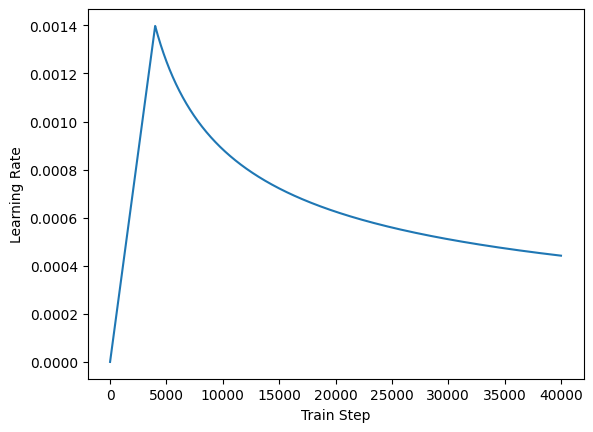

In [53]:
# 40000 스텝까지의 학습률 스케줄 시각화
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')  # y축 레이블: '학습률'
plt.xlabel('Train Step')    # x축 레이블: '훈련 스텝'

### loss and metric 설정

In [54]:
def masked_loss(label, pred):
  mask = label != 0   # 레이블이 0인 부분은 마스크 처리
  # SparseCategoricalCrossentropy 손실 함수 초기화
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  # 손실 계산
  loss = loss_object(label, pred)

  # 마스크를 손실의 데이터 타입으로 캐스팅
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask    # 마스크를 적용하여 불필요한 손실 제거

  # 마스크를 적용한 손실의 합을 마스크의 합으로 나누어 평균 손실 계산
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  # 예측값에서 가장 큰 값의 인덱스를 선택
  pred = tf.argmax(pred, axis=2)
  # 레이블을 예측값의 데이터 타입으로 캐스팅
  label = tf.cast(label, pred.dtype)
  # 예측값과 레이블이 일치하는지 여부
  match = label == pred

  mask = label != 0   # 레이블이 0인 부분은 마스크 처리

  # 마스크 적용하여 정확한 예측만 선택
  match = match & mask

  # 일치 여부와 마스크를 float 타입으로 캐스팅
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  # 마스크를 적용한 정확도의 합을 마스크의 합으로 나누어 평균 정확도 계산
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### model Train

In [55]:
# 트랜스포머 모델 컴파일
transformer.compile(
    loss=masked_loss,             # 마스킹된 손실 함수
    optimizer=optimizer,          # 최적화 알고리즘
    metrics=[masked_accuracy])    # 마스킹된 정확도를 평가 지표로 사용

In [56]:
transformer.fit(train_batches,
                epochs=5,
                validation_data=val_batches)

Epoch 1/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3099s 8s/step - loss: 7.6156 - masked_accuracy: 0.0875 - val_loss: 6.1152 - val_masked_accuracy: 0.1712
Epoch 2/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 2920s 7s/step - loss: 5.3196 - masked_accuracy: 0.2315 - val_loss: 4.7211 - val_masked_accuracy: 0.2865
Epoch 3/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3058s 8s/step - loss: 4.3737 - masked_accuracy: 0.3268 - val_loss: 4.0705 - val_masked_accuracy: 0.3588
Epoch 4/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3194s 8s/step - loss: 3.7675 - masked_accuracy: 0.3927 - val_loss: 3.5537 - val_masked_accuracy: 0.4235
Epoch 5/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 3337s 8s/step - loss: 3.2545 - masked_accuracy: 0.4469 - val_loss: 3.1966 - val_masked_accuracy: 0.4635


## 추론

In [57]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers      # 토크나이저
    self.transformer = transformer  # 트랜스포머 모델

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # 입력 문장이 포르투갈어이므로 `[START]`와 `[END]` 토큰을 추가
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # 출력 언어가 영어이므로 영어 `[START]` 토큰으로 초기화
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # 동적 루프 추적을 위해 `tf.TensorArray` 사용
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # `seq_len` 차원에서 마지막 토큰 선택
      predictions = predictions[:, -1:, :]  # 형상: `(batch_size, 1, vocab_size)`

      predicted_id = tf.argmax(predictions, axis=-1)

      # `predicted_id`를 출력에 연결
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]  # 형상: `()`

    tokens = tokenizers.en.lookup(output)[0]

    # 루프의 마지막 반복에서 계산된 어텐션 가중치를 사용할 수 없으므로,
    # 루프 밖에서 다시 계산
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [58]:
translator = Translator(tokenizers, transformer)

In [59]:
#함수는 세 가지 인자를 받습니다:
# sentence: 번역할 원문 문장
# tokens: 토큰화된 번역 결과입니다. 이 값은 numpy 배열로 변환되고 UTF-8로 디코딩됩니다.
# ground_truth: 실제 번역 결과
def print_translation(sentence, tokens, ground_truth):
  # 입력 문장 출력
  print(f'{"Input:":15s}: {sentence}')
  # 모델의 예측 번역 출력
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  # 실제 번역 (ground truth) 출력
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [60]:
# 포르투갈어 문장
sentence = 'este é um problema que temos que resolver.'
# 실제 번역 (ground truth)
ground_truth = 'this is a problem we have to solve .'

# Translator를 사용하여 포르투갈어 문장 번역
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# 번역 결과 출력
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Ground truth   : this is a problem we have to solve .


Example 2:

In [61]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors have heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [62]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly quickly with you can share some stories of things that are happening . that ' s happening .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## attention plot 생성

In [63]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is first book i did . i did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Ground truth   : this is the first book i've ever done.


토큰이 생성될 때 attention을 plot하는 함수를 만듭니다.

In [64]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # 모델이 출력에서 `<START>`를 생성하지 않았으므로 이를 생략합니다.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()  # 현재 축 가져오기
  ax.matshow(attention)  # 어텐션 맵 시각화
  ax.set_xticks(range(len(in_tokens)))  # x축 틱 설정
  ax.set_yticks(range(len(translated_tokens)))  # y축 틱 설정

  # 입력 토큰 레이블
  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)  # x축 틱 레이블 설정 및 회전

  # 번역된 토큰 레이블
  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)  # y축 틱 레이블 설정

In [65]:
head = 0  # 검사할 어텐션 헤드 번호
# 어텐션 가중치의 형상: `(batch=1, num_heads, seq_len_q, seq_len_k)`
attention_heads = tf.squeeze(attention_weights, 0)  # 배치 차원 제거
attention = attention_heads[head]  # 특정 어텐션 헤드 선택
attention.shape  # 선택된 어텐션 헤드의 형상

TensorShape([51, 11])

입력(포르투갈어) 토큰은 다음과 같습니다.

In [66]:
# 입력 문장을 텐서로 변환
in_tokens = tf.convert_to_tensor([sentence])
# 포르투갈어 토크나이저를 사용하여 토큰화
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
# 토큰 인덱스를 실제 단어로 변환
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens  # 토큰화된 입력 문장 출력

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

다음은 출력(영어 번역) 토큰입니다.

In [67]:
translated_tokens

<tf.Tensor: shape=(52,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'first', b'book', b'i', b'did', b'.',
       b'i', b'did', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.',
       b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.',
       b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.',
       b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.', b'.',
       b'[END]'], dtype=object)>

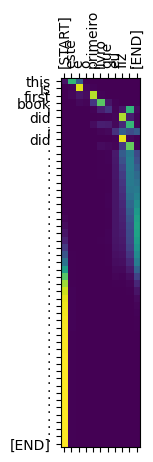

In [76]:
# 어텐션 맵 시각화
plot_attention_head(in_tokens, translated_tokens, attention)

In [84]:
#번역할 문장(sentence), 번역된 토큰(translated_tokens), 어텐션 헤드들의 가중치(attention_heads)를 입력으로 받습니다.

def plot_attention_weights(sentence, translated_tokens, attention_heads):
  # 입력 문장을 텐서로 변환하고 토큰화
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  # 시각화를 위한 그래프 설정
  fig = plt.figure(figsize=(16, 8))

  # 각 어텐션 헤드에 대한 어텐션 맵을 그래프로 표시
  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)  # 2x4 격자에 그래프 배치

    plot_attention_head(in_tokens, translated_tokens, head)  # 어텐션 헤드별 맵 그리기

    ax.set_xlabel(f'Head {h+1}')  # x축 레이블 설정

  plt.tight_layout()  # 그래프 레이아웃 조정
  plt.show()  # 그래프 표시

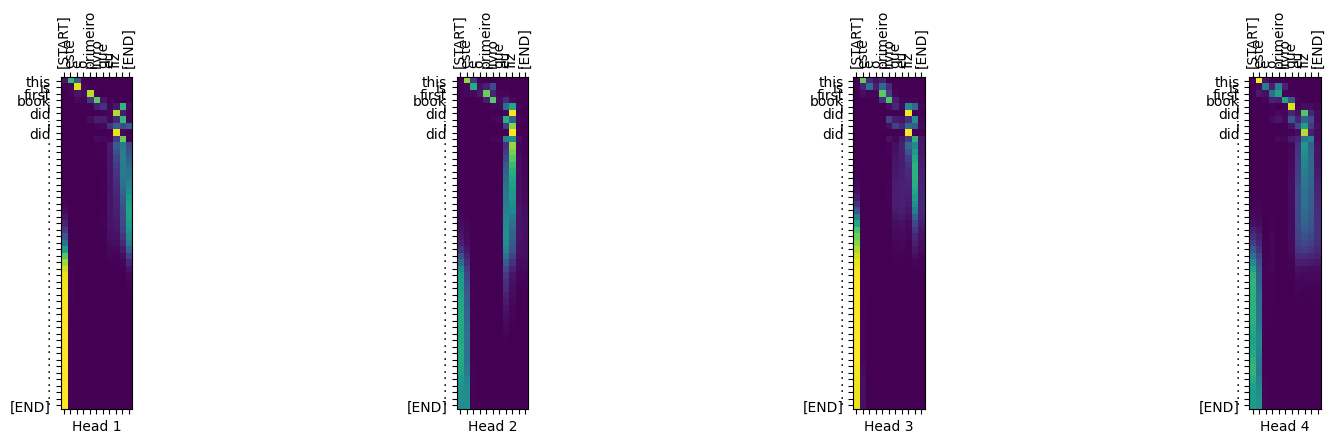

In [85]:
# 주어진 문장, 번역된 토큰, 첫 번째 어텐션 헤드의 가중치를 사용하여 어텐션 맵 시각화
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])  # 첫 번째 어텐션 헤드의 가중치

## model export

모델을 테스트했으며 추론이 작동하고 있습니다. 다음으로 `tf.saved_model`로 내보낼 수 있습니다.

In [71]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator  # 번역기 객체

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    # translator 객체를 사용하여 주어진 문장을 번역
    (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result  # 번역 결과 반환

In [72]:
translator = ExportTranslator(translator)

In [73]:
translator('este é o primeiro livro que eu fiz.').numpy()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_self_attention_4' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_3' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'causal_self_attention_4' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

b'this is first book i did . i did . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

먼저 노트북 RAM이 너무 부족해서 원래 설정 그대로는 Transformer 모델이 제대로 돌아가지 않는 문제가 있었다. 학습을 몇 번 돌려보니 batch_size를 크게 잡으면 곧바로 OOM(Out Of Memory) 에러가 났고, 반대로 너무 작게 잡으면 epoch당 step 수가 800개가 넘어서 한 번 학습시키는 데 시간이 너무 오래 걸렸다. 그래서 모델 용량과 메모리 사용량을 줄이기 위해 하이퍼파라미터를 전반적으로 조정했다.

모델 구조는 `num_layers = 2`, `d_model = 128`, `dff = 512`, `num_heads = 4`, `dropout_rate = 0.1`로 줄여서 인코더/디코더 블록 수와 임베딩 차원을 축소했다.  이런 식으로 모델 크기와 batch_size를 같이 조정해서, RAM을 넘지 않는 선에서 모델이 돌아가는(?) 부분에 의의를 두고 진행했다. 어텐션 맵 또한 버전이 안맞아서 심각하게 깨졌다..

GPU의 소중함을 크게 느끼는 과제였고 연구실 컴퓨터로 다시 한번 찬찬히 제대로 모델을 완성 시키고싶다. 아쉬움이 크게 남는 과제였다 ㅠ
